In [1]:
import pandas as pd

In [2]:
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.datasets import load_unit_test
df_train, df_train_y= load_unit_test(split="train")
df_test, df_test_y = load_unit_test(split="test")


In [3]:
df_train['class']=df_train_y
df_test['class']=df_test_y

In [4]:
from pypelines import ts_classification_pipeline as pipe

In [5]:
tsc = pipe.TSClassificationPipeline(data=df_train,
                                    target_column='class',
                                    models=['MLP'],
                                    test_data=df_test,positive_class='2')


In [6]:
tsc.code_to_clipboard()

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1/1 [==============================] - 0s 67ms/step
[CV 1/3] END ......................n_epochs=100;, score=1.000 total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1/1 [==============================] - 0s 69ms/step
[CV 2/3] END ......................n_epochs=100;, score=1.000 total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1/1 [==============================] - 0s 69ms/step
[CV 3/3] END ......................n_epochs=100;, score=1.000 total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1/1 [==============================] - 0s 72ms/step
[CV 1/3] END .....................n_epochs=1100;, score=1.000 total time=  11.0s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1/1 [==============================] - 0s 73ms/step
[CV 2/3] END .....................n_epochs=1100;, score=0.857 total time=  13.2s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1/1 [==============================] - 0s 66ms/step
[CV 3/3] END .....................n_epochs=1100;, score=1.000 total time=  12.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2/2 [==============================] - 0s 8ms/step
           model         metric     value
4  MLPClassifier  roc_auc_score  0.916667
           model         metric     value
4  MLPClassifier  roc_auc_score  0.916667
The best model is MLPClassifier with 0.9166666666666666 as roc_auc_score
2/2 [==============================] - 0s 3ms/step
Predictions from best model are stored in test_predictions


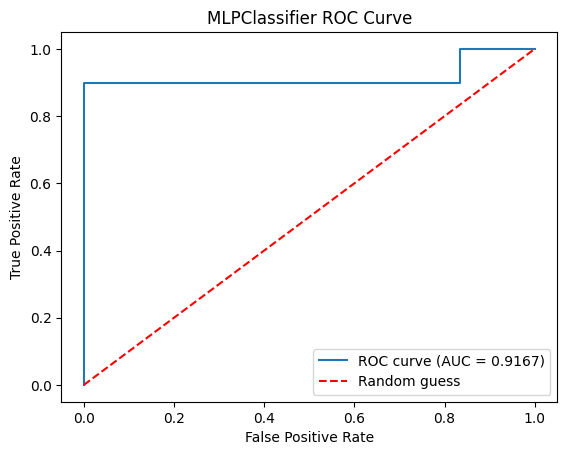

In [8]:

from sktime import *
from sklearn.metrics import accuracy_score


import pandas as pd
import numpy as np


# target dataframe: df_train
target = "class"
features = list(df_train.columns.drop("class"))

# train test split
X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

model_comparison_list = []

##### End of Data Processing Pipeline #####


##### Model Pipeline for MLP #####

from sktime.classification.deep_learning.mlp import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,make_scorer,f1_score,precision_score,recall_score,roc_auc_score,roc_curve,auc
import matplotlib.pyplot as plt
MLPClassifier_param_grid = {
"n_epochs": np.arange(100, 2000, 1000),
}

MLPClassifier_model = MLPClassifier()

# Create the grid search
MLPClassifier_grid_search = GridSearchCV(estimator=MLPClassifier_model, param_grid=MLPClassifier_param_grid, cv=3, scoring=make_scorer(accuracy_score), verbose=3)
MLPClassifier_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
MLPClassifier_best_estimator = MLPClassifier_grid_search.best_estimator_

# Store results as a dataframe  
MLPClassifier_search_results = pd.DataFrame(MLPClassifier_grid_search.cv_results_)

# Generate Predictions
MLPClassifier_predictions = pd.DataFrame(MLPClassifier_best_estimator.predict(X_test))
MLPClassifier_predictions_prob = MLPClassifier_best_estimator.predict_proba(X_test)
MLPClassifier_predictions_prob_df = pd.DataFrame()
MLPClassifier_predictions_prob_df[MLPClassifier_grid_search.classes_[0]] = MLPClassifier_predictions_prob[:,0]
MLPClassifier_predictions_prob_df[MLPClassifier_grid_search.classes_[1]] = MLPClassifier_predictions_prob[:,1] 


# Generate Model Metrics
MLPClassifier_accuracy = accuracy_score(y_test, MLPClassifier_predictions.iloc[:,0])
MLPClassifier_f1_score = f1_score(y_test, MLPClassifier_predictions.iloc[:,0],pos_label='2')
MLPClassifier_precision = precision_score(y_test, MLPClassifier_predictions.iloc[:,0],pos_label='2')
MLPClassifier_recall = recall_score(y_test, MLPClassifier_predictions.iloc[:,0],pos_label='2')
MLPClassifier_roc_auc_score = roc_auc_score(y_test, MLPClassifier_predictions_prob_df[MLPClassifier_grid_search.classes_[1]])
MLPClassifier_performance_metrics = [['MLPClassifier','accuracy',MLPClassifier_accuracy], 
                                  ['MLPClassifier','f1_score',MLPClassifier_f1_score],
                                  ['MLPClassifier','precision', MLPClassifier_precision],
                                  ['MLPClassifier','recall', MLPClassifier_recall],
                                  ['MLPClassifier','roc_auc_score', MLPClassifier_roc_auc_score]]
MLPClassifier_performance_metrics = pd.DataFrame(MLPClassifier_performance_metrics, columns=['model','metric', 'value'])
fpr, tpr, thresholds = roc_curve(y_test, MLPClassifier_predictions_prob_df[MLPClassifier_grid_search.classes_[1]],pos_label='2')
roc_auc = auc(fpr, tpr)

# ROC Curve plot
MLPClassifier_roc_auc_plot, MLPClassifier_roc_auc_plot_ax = plt.subplots()
MLPClassifier_roc_auc_plot_ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
MLPClassifier_roc_auc_plot_ax.plot([0, 1], [0, 1], 'r--', label='Random guess')
# Set axis labels and title
MLPClassifier_roc_auc_plot_ax.set_xlabel('False Positive Rate')
MLPClassifier_roc_auc_plot_ax.set_ylabel('True Positive Rate')
MLPClassifier_roc_auc_plot_ax.set_title(f'MLPClassifier ROC Curve')
# Add legend
MLPClassifier_roc_auc_plot_ax.legend()


print(MLPClassifier_performance_metrics[MLPClassifier_performance_metrics['metric'] == 'roc_auc_score'])
model_comparison_list.append(MLPClassifier_performance_metrics)##### End of Model Pipeline for MLP #####
##### Model Comparison #####
table = pd.concat(model_comparison_list)
table = table.sort_values(by=['value'], ascending=False)
table = table[table['metric'] == 'roc_auc_score']
print(table)
print(f"The best model is {table['model'].iloc[0]} with {table['value'].iloc[0]} as {table['metric'].iloc[0]}")

# Predict test data using the best model
test_predictions = eval(table['model'].iloc[0]+"_best_estimator").predict(X_test)
print('Predictions from best model are stored in test_predictions')
